# Econ 281: Computational Tools in Macroeconomics

### Homework 7: Sequence space methods

##### Youngdoo Choi (yoc005@ucsd.edu), May 2024

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import time
from sequence_jacobian import simple, create_model, drawdag

---

### In-class example: Solve RBC model without labor

In [2]:
# Set parameters
gamma = 1.0
alpha = 0.33
beta = 0.95
delta = 0.025
sc = 0.8
T = 100

In [3]:
# Assign sparce matrices
I = sp.sparse.eye(T)
Ip1 = sp.sparse.diags([np.ones(T-1)], [1], (T, T))     # upper
Im1 = sp.sparse.diags([np.ones(T-1)], [-1], (T, T))    # lower
Z = sp.sparse.csr_matrix((T, T))

#### 1. Solve with a single block

In [4]:
# Assign the coefficients
coef_1 = gamma * (alpha + (1-sc)*(1-delta)/delta) 
coef_2 = -gamma * (alpha + (1-sc)*(2-delta)/delta + (1-alpha)*sc*(1-beta*(1-delta)))
coef_3 = gamma * (1-sc) / delta
coef_4 = gamma
coef_5 = -(gamma - sc*(1-beta*(1-delta)))

In [5]:
# Calculate the matrices
H_K = coef_2*I + coef_3*Ip1 + coef_1*Im1
H_Z = coef_4*I + coef_5*Ip1

In [6]:
# Simulate the shock
dZ = np.zeros((T, 1))
dZ[0] = 1
rho = 0.9
for t in range(1, T):
    dZ[t] = rho*dZ[t-1]

In [7]:
# Solve for dU
dU = -sp.sparse.linalg.spsolve(H_K, H_Z @ sp.sparse.csr_matrix(dZ))

/var/folders/jx/cvyfhs3900vf4n0lf1sp1lz80000gn/T/ipykernel_22517/283833195.py:2: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format


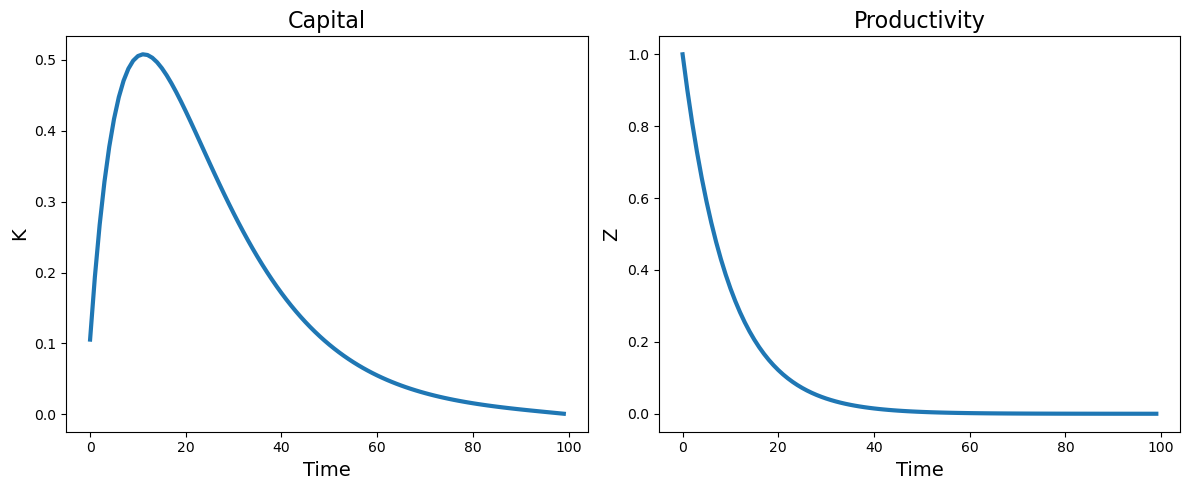

In [8]:
# Plot the graph
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(range(T), dU, linewidth=3)
axs[0].set_xlabel('Time', fontsize=14)
axs[0].set_ylabel('K', fontsize=14)
axs[0].set_title('Capital', fontsize=16)

axs[1].plot(range(T), dZ, linewidth=3)
axs[1].set_xlabel('Time', fontsize=14)
axs[1].set_ylabel('Z', fontsize=14)
axs[1].set_title('Productivity', fontsize=16)

plt.tight_layout()
plt.show()

#### 2. Solve with agent blocks

In [9]:
# Define agent blocks
@simple
def firm(z, k):
    # y = z + alpha * k(-1)
    # mpk = z(+1) + (alpha-1) * k
    return y, mpk
    
@simple
def household(mpk, k):
    # i = (k - (1-delta) * k(-1)) / delta
    # c = c(+1) - (1-beta*(1-delta))/gamma * mpk
    return c, i

@simple
def mkt_clearing(y, c, i):
    # good_mkt = sc * c + (1-sc) * i - y
    return good_mkt

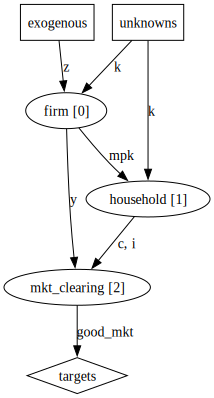

In [10]:
# Draw DAG representation
rbc = create_model([firm, household, mkt_clearing])

unknowns = ['k']
inputs = ['z']
targets = ['good_mkt']

drawdag(rbc, inputs, unknowns, targets)

In [11]:
# 1. Define firm block

# Production function
Phi_y_k = alpha * Im1
Phi_y_z = I

# Optimal condition
Phi_mpk_k = (alpha-1) * I
Phi_mpk_z = Ip1

In [12]:
# 2. Define household block

# Law of motion
Phi_i_k = (I + (delta-1) * Im1) / delta
Phi_i_mpk = Z

# Euler equation
Phi_c_k = Z
Phi_c_mpk = sp.sparse.linalg.spsolve(I - Ip1, -1/gamma * (1-beta*(1-delta)) * I)

/Users/youngdoo/anaconda3/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
/var/folders/jx/cvyfhs3900vf4n0lf1sp1lz80000gn/T/ipykernel_22517/3612240214.py:9: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format


In [13]:
# 3. Construct market clearing block

# dH/dY
Phi_gm_c = sc * I
Phi_gm_i = (1-sc) * I
Phi_gm_y = -I
Phi_gm_mpk = Z
dH_dY = sp.sparse.hstack([Phi_gm_c, Phi_gm_i, Phi_gm_y, Phi_gm_mpk], format='csr')

# dY/dU
dY_dU = sp.sparse.vstack([Phi_c_mpk @ Phi_mpk_k, Phi_i_k, Phi_y_k, Phi_mpk_k], format='csr')

# dY/dZ
dY_dZ = sp.sparse.vstack([Phi_c_mpk @ Phi_mpk_z, Phi_i_mpk @ Phi_mpk_z, Phi_y_z, Phi_mpk_z], format='csr')

# H_U = dH/dY * dY/dU
H_U = dH_dY @ dY_dU

# H_Z = dH/dY * dY/dZ
H_Z = dH_dY @ dY_dZ

In [14]:
# Solve for the same shock
dU = -sp.sparse.linalg.spsolve(H_U, H_Z @ sp.sparse.csr_matrix(dZ))
dY = (dY_dU @ dU).reshape(400, 1) + dY_dZ @ dZ

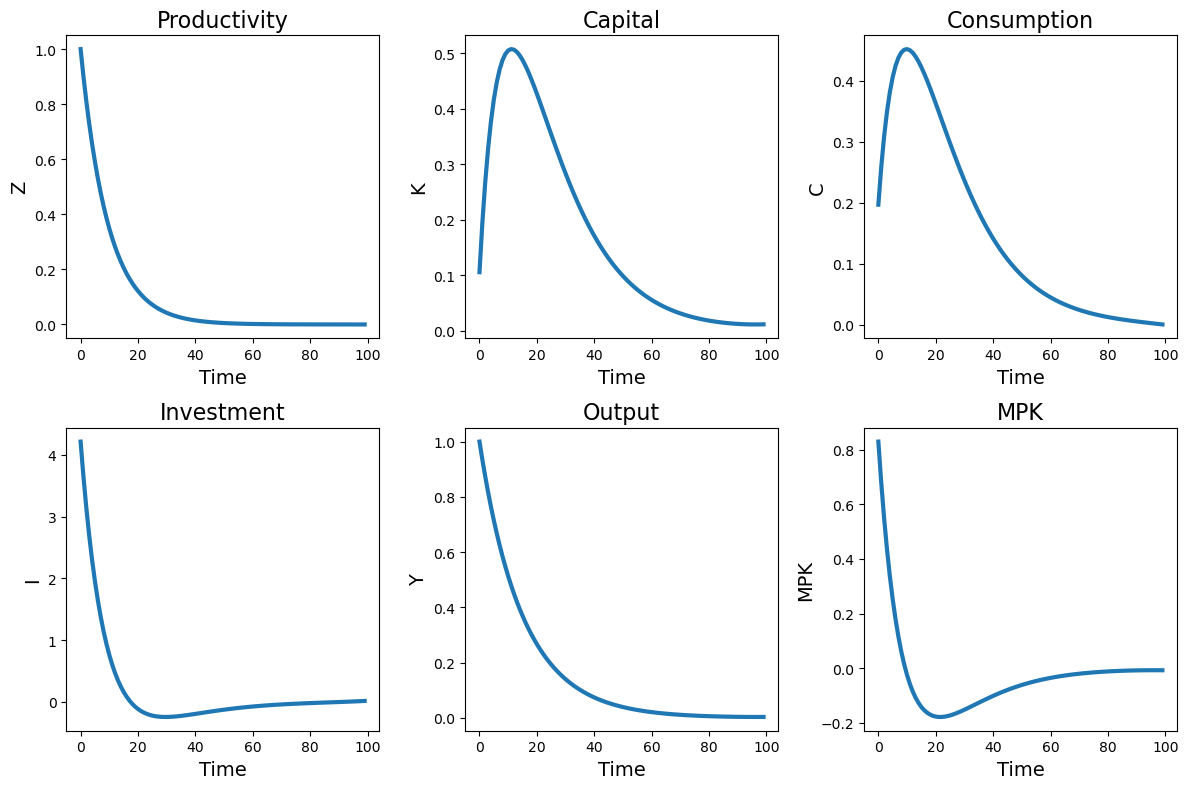

In [15]:
# Plot the graph
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

axs[0, 0].plot(range(T), dZ, linewidth=3)
axs[0, 0].set_xlabel('Time', fontsize=14)
axs[0, 0].set_ylabel('Z', fontsize=14)
axs[0, 0].set_title('Productivity', fontsize=16)

axs[0, 1].plot(range(T), dU, linewidth=3)
axs[0, 1].set_xlabel('Time', fontsize=14)
axs[0, 1].set_ylabel('K', fontsize=14)
axs[0, 1].set_title('Capital', fontsize=16)

axs[0, 2].plot(range(T), dY[:T], linewidth=3)
axs[0, 2].set_xlabel('Time', fontsize=14)
axs[0, 2].set_ylabel('C', fontsize=14)
axs[0, 2].set_title('Consumption', fontsize=16)

axs[1, 0].plot(range(T), dY[T:2*T], linewidth=3)
axs[1, 0].set_xlabel('Time', fontsize=14)
axs[1, 0].set_ylabel('I', fontsize=14)
axs[1, 0].set_title('Investment', fontsize=16)

axs[1, 1].plot(range(T), dY[2*T:3*T], linewidth=3)
axs[1, 1].set_xlabel('Time', fontsize=14)
axs[1, 1].set_ylabel('Y', fontsize=14)
axs[1, 1].set_title('Output', fontsize=16)

axs[1, 2].plot(range(T), dY[3*T:4*T], linewidth=3)
axs[1, 2].set_xlabel('Time', fontsize=14)
axs[1, 2].set_ylabel('MPK', fontsize=14)
axs[1, 2].set_title('MPK', fontsize=16)

plt.tight_layout()
plt.show()

---

### Homework 1: Solve RBC model without capital

Optimal conditions:

\begin{align*}
\hat{y}_t = \hat{z}_t + \hat{n}_t \\
\hat{mpl}_t = \hat{z}_t \\
\gamma \hat{c}_t + \nu \hat{n}_t = \hat{mpl}_t \\
\hat{y}_t = \hat{c}_t
\end{align*}

In [16]:
# Set parameters
nu = 1.0

In [17]:
# Define agent blocks
@simple
def firm(z, n):
    return y, mpl
    
@simple
def household(n, mpl):
    return c

@simple
def mkt_clearing(y, c):
    return good_mkt

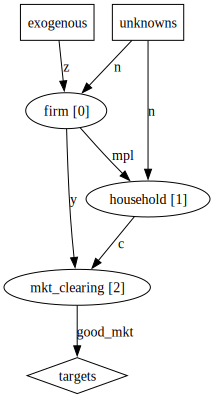

In [18]:
# Draw DAG representation
rbc_without_capital = create_model([firm, household, mkt_clearing])

unknowns = ['n']
inputs = ['z']
targets = ['good_mkt']

drawdag(rbc_without_capital, inputs, unknowns, targets)

In [19]:
# 1. Define firm block

# Production function
Phi_y_n = I
Phi_y_z = I

# Optimal condition
Phi_mpl_n = Z
Phi_mpl_z = I

In [20]:
# 2. Define household block

# Labor supply
Phi_c_n = -nu/gamma * I
Phi_c_mpl = I / gamma

In [21]:
# 3. Construct market clearing block

# dH/dY
Phi_gm_c = I
Phi_gm_y = -I
Phi_gm_mpl = Z
dH_dY = sp.sparse.hstack([Phi_gm_c, Phi_gm_y, Phi_gm_mpl], format='csr')

# dY/dU
dY_dU = sp.sparse.vstack([Phi_c_n, Phi_y_n, Phi_mpl_n], format='csr')

# dY/dZ
dY_dZ = sp.sparse.vstack([Phi_c_mpl @ Phi_mpl_z, Phi_y_z, Phi_mpl_z], format='csr')

# H_U = dH/dY * dY/dU
H_U = dH_dY @ dY_dU

# H_Z = dH/dY * dY/dZ
H_Z = dH_dY @ dY_dZ

In [22]:
# Solve for the same shock
dU = -sp.sparse.linalg.spsolve(H_U, H_Z @ sp.sparse.csr_matrix(dZ))
dY = (dY_dU @ dU).reshape(300, 1) + dY_dZ @ dZ

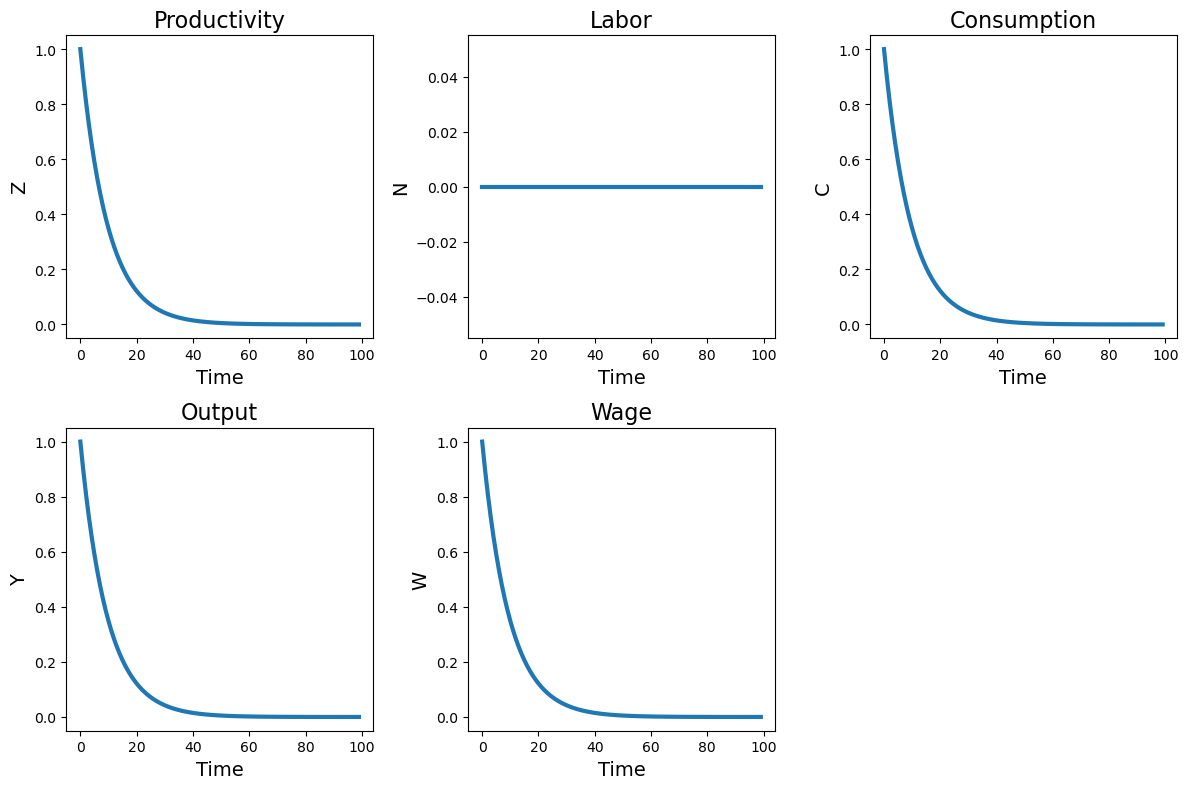

In [23]:
# Plot the graph
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

axs[0, 0].plot(range(T), dZ, linewidth=3)
axs[0, 0].set_xlabel('Time', fontsize=14)
axs[0, 0].set_ylabel('Z', fontsize=14)
axs[0, 0].set_title('Productivity', fontsize=16)

axs[0, 1].plot(range(T), dU, linewidth=3)
axs[0, 1].set_xlabel('Time', fontsize=14)
axs[0, 1].set_ylabel('N', fontsize=14)
axs[0, 1].set_title('Labor', fontsize=16)

axs[0, 2].plot(range(T), dY[:T], linewidth=3)
axs[0, 2].set_xlabel('Time', fontsize=14)
axs[0, 2].set_ylabel('C', fontsize=14)
axs[0, 2].set_title('Consumption', fontsize=16)

axs[1, 0].plot(range(T), dY[T:2*T], linewidth=3)
axs[1, 0].set_xlabel('Time', fontsize=14)
axs[1, 0].set_ylabel('Y', fontsize=14)
axs[1, 0].set_title('Output', fontsize=16)

axs[1, 1].plot(range(T), dY[2*T:3*T], linewidth=3)
axs[1, 1].set_xlabel('Time', fontsize=14)
axs[1, 1].set_ylabel('W', fontsize=14)
axs[1, 1].set_title('Wage', fontsize=16)

fig.delaxes(axs[1, 2])

plt.tight_layout()
plt.show()

---

### Homework 2: Solve RBC model with capital

Optimal conditions:

\begin{align*}
\hat{y}_t = \hat{z}_t + \alpha \hat{k}_{t-1} + (1-\alpha) \hat{n}_t \\
\hat{mpk}_{t+1} = \hat{z}_{t+1} + (\alpha-1) \hat{k}_t + (1-\alpha) \hat{n}_{t+1} \\
\hat{mpl}_t = \hat{z}_t + \alpha \hat{k}_{t-1} -\alpha \hat{n}_t \\
\hat{k}_t = \delta \hat{i}_t + (1-\delta) \hat{k}_{t-1} \\
\gamma \hat{c}_t + \nu \hat{n}_t = \hat{mpl}_t \\
0 = s_c \hat{c}_t + (1-s_c) \hat{i}_t - \hat{y}_t \\
0 = (1-\beta (1-\delta)) \hat{mpk}_{t+1} - \gamma (\hat{c}_{t+1} - \hat{c}_t)
\end{align*}

In [24]:
# Define agent blocks
@simple
def firm(z, k, n):
    return y, mpk, mpl
    
@simple
def household(k, n, mpl):
    return c, i

@simple
def mkt_clearing(y, c, i, mpk):
    return good_mkt, euler

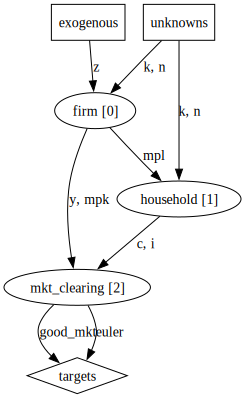

In [25]:
# Draw DAG representation
rbc_with_capital = create_model([firm, household, mkt_clearing])

unknowns = ['k', 'n']
inputs = ['z']
targets = ['good_mkt', 'euler']

drawdag(rbc_with_capital, inputs, unknowns, targets)

In [26]:
# 1. Define firm block

# Production function
Phi_y_k = alpha * Im1
Phi_y_n = (1-alpha) * I
Phi_y_z = I

# Optimal condition - capital
Phi_mpk_k = (alpha-1) * I
Phi_mpk_n = (1-alpha) * Ip1
Phi_mpk_z = Ip1

# Optimal condition - labor
Phi_mpl_k = alpha * Im1
Phi_mpl_n = -alpha * I
Phi_mpl_z = I

In [27]:
# 2. Define household block

# Law of motion
Phi_i_k = (I + (delta-1) * Im1) / delta
Phi_i_n = Z
Phi_i_mpl = Z

# Labor supply
Phi_c_k = Z
Phi_c_n = -nu/gamma * I
Phi_c_mpl = I / gamma

In [28]:
# 3. Construct market clearing block

# dH/dY
Phi_gm_c = sc * I
Phi_gm_i = (1-sc) * I
Phi_gm_y = -I
Phi_gm_mpk = Z
Phi_gm_mpl = Z

Phi_euler_c = gamma * (I - Ip1)
Phi_euler_i = Z
Phi_euler_y = Z
Phi_euler_mpk = (1-beta*(1-delta)) * I
Phi_euler_mpl = Z

dH1_dY = sp.sparse.hstack([Phi_gm_c, Phi_gm_i, Phi_gm_y, Phi_gm_mpk, Phi_gm_mpl], format='csr')
dH2_dY = sp.sparse.hstack([Phi_euler_c, Phi_euler_i, Phi_euler_y, Phi_euler_mpk, Phi_euler_mpl], format='csr')
dH_dY = sp.sparse.vstack([dH1_dY, dH2_dY], format='csr')

# dY/dU
dY_dK = sp.sparse.vstack([Phi_c_mpl @ Phi_mpl_k, Phi_i_k, Phi_y_k, Phi_mpk_k, Phi_mpl_k], format='csr')
dY_dN = sp.sparse.vstack([Phi_c_n + Phi_c_mpl @ Phi_mpl_n, Phi_i_mpl @ Phi_mpl_n, Phi_y_n, Phi_mpk_n, Phi_mpl_n], format='csr')
dY_dU = sp.sparse.hstack([dY_dK, dY_dN], format='csr')

# dY/dZ
dY_dZ = sp.sparse.vstack([Phi_c_mpl @ Phi_mpl_z, Phi_i_mpl @ Phi_mpl_z, Phi_y_z, Phi_mpk_z, Phi_mpl_z], format='csr')

# H_U = dH/dY * dY/dU
H_U = dH_dY @ dY_dU

# H_Z = dH/dY * dY/dZ
H_Z = dH_dY @ dY_dZ

In [29]:
# Solve for the same shock
dU = -sp.sparse.linalg.spsolve(dH_dY @ dY_dU, H_Z @ sp.sparse.csr_matrix(dZ))
dK = dU[:T]
dN = dU[T:2*T]

dY = (dY_dU @ dU).reshape(500, 1) + dY_dZ @ dZ

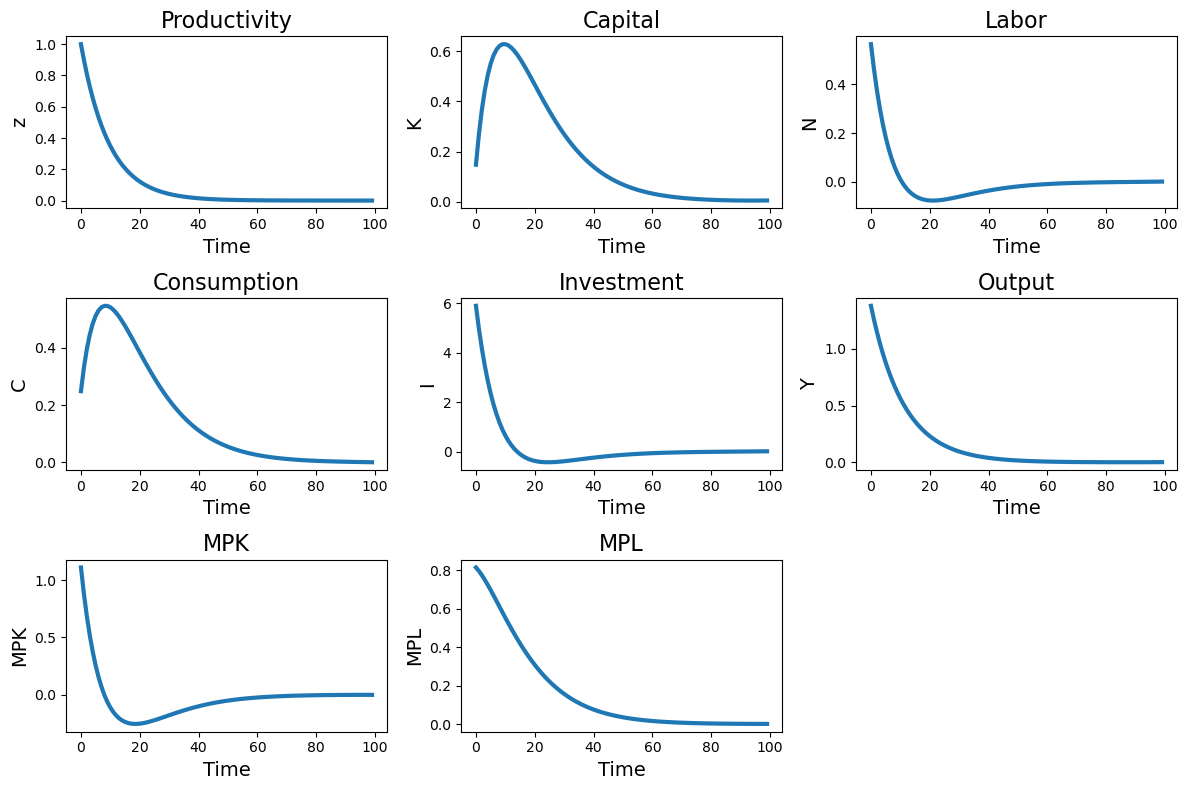

In [30]:
# Plot the graph
fig, axs = plt.subplots(3, 3, figsize=(12, 8))

axs[0, 0].plot(range(T), dZ, linewidth=3)
axs[0, 0].set_xlabel('Time', fontsize=14)
axs[0, 0].set_ylabel('z', fontsize=14)
axs[0, 0].set_title('Productivity', fontsize=16)

axs[0, 1].plot(range(T), dU[:T], linewidth=3)
axs[0, 1].set_xlabel('Time', fontsize=14)
axs[0, 1].set_ylabel('K', fontsize=14)
axs[0, 1].set_title('Capital', fontsize=16)

axs[0, 2].plot(range(T), dU[T:2*T], linewidth=3)
axs[0, 2].set_xlabel('Time', fontsize=14)
axs[0, 2].set_ylabel('N', fontsize=14)
axs[0, 2].set_title('Labor', fontsize=16)

axs[1, 0].plot(range(T), dY[:T], linewidth=3)
axs[1, 0].set_xlabel('Time', fontsize=14)
axs[1, 0].set_ylabel('C', fontsize=14)
axs[1, 0].set_title('Consumption', fontsize=16)

axs[1, 1].plot(range(T), dY[T:2*T], linewidth=3)
axs[1, 1].set_xlabel('Time', fontsize=14)
axs[1, 1].set_ylabel('I', fontsize=14)
axs[1, 1].set_title('Investment', fontsize=16)

axs[1, 2].plot(range(T), dY[2*T:3*T], linewidth=3)
axs[1, 2].set_xlabel('Time', fontsize=14)
axs[1, 2].set_ylabel('Y', fontsize=14)
axs[1, 2].set_title('Output', fontsize=16)

axs[2, 0].plot(range(T), dY[3*T:4*T], linewidth=3)
axs[2, 0].set_xlabel('Time', fontsize=14)
axs[2, 0].set_ylabel('MPK', fontsize=14)
axs[2, 0].set_title('MPK', fontsize=16)

axs[2, 1].plot(range(T), dY[4*T:5*T], linewidth=3)
axs[2, 1].set_xlabel('Time', fontsize=14)
axs[2, 1].set_ylabel('MPL', fontsize=14)
axs[2, 1].set_title('MPL', fontsize=16)

fig.delaxes(axs[2, 2])

plt.tight_layout()
plt.show()

---

### Homework 3: Solve NK model with capital

Optimal conditions:

\begin{align*}
\hat{y}_t = \hat{y}_{t+1} - (\hat{i_t} - \hat{\pi}_{t+1}) / \gamma \\
\hat{\pi}_t = \kappa (\hat{y}_t - \frac{1+\nu}{\gamma+\nu} \hat{z}_t) + \beta \hat{\pi}_{t+1} \\
\hat{i}_t = \phi_\pi \hat{\pi}_t
\end{align*}

In [31]:
# Set parameters
theta = 3/4
lambd = (1-theta) * (1-beta*theta) / theta
kappa = lambd * (gamma + nu)
phi_pi = 1.5

In [32]:
# Define agent blocks
@simple
def firm(z, y):
    return pi

@simple
def household(y, pi):
    return i

@simple
def monetary_policy(pi, i):
    return taylor_rule

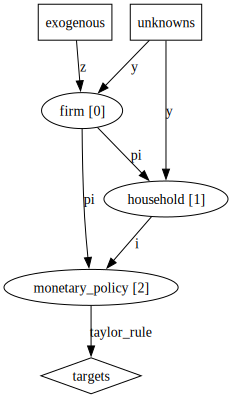

In [33]:
# Draw DAG representation
nk_with_capital = create_model([monetary_policy, household, firm])

unknowns = ['y']
inputs = ['z']
targets = ['taylor_rule']

drawdag(nk_with_capital, inputs, unknowns, targets)

In [34]:
# 1. Define firm block

# Phillips curve
Phi_pi_y = sp.sparse.linalg.spsolve(I - beta * Ip1, kappa * I)
Phi_pi_z = sp.sparse.linalg.spsolve(I - beta * Ip1, -kappa * (1+nu)/(gamma+nu) * I)

/Users/youngdoo/anaconda3/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
/var/folders/jx/cvyfhs3900vf4n0lf1sp1lz80000gn/T/ipykernel_22517/245015592.py:4: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
/var/folders/jx/cvyfhs3900vf4n0lf1sp1lz80000gn/T/ipykernel_22517/245015592.py:5: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format


In [35]:
# 2. Define household block

# Euler eq.
Phi_i_y = gamma * (Ip1 - I)
Phi_i_pi = Ip1

In [36]:
# 3. Construct market clearing block

# dH/dY
Phi_tr_pi = phi_pi * I
Phi_tr_i = -I
dH_dY = sp.sparse.hstack([Phi_tr_pi, Phi_tr_i], format='csr')

# dY/dU
dY_dU = sp.sparse.vstack([Phi_pi_y, Phi_i_y], format='csr')

# dY/dZ
dY_dZ = sp.sparse.vstack([Phi_pi_z, Phi_i_pi @ Phi_pi_z], format='csr')

# H_U = dH/dY * dY/dU
H_U = dH_dY @ dY_dU

# H_Z = dH/dY * dY/dZ
H_Z = dH_dY @ dY_dZ

In [37]:
# Solve for the same shock
dU = -sp.sparse.linalg.spsolve(dH_dY @ dY_dU, H_Z @ sp.sparse.csr_matrix(dZ))

dY = (dY_dU @ dU).reshape(200, 1) + dY_dZ @ dZ

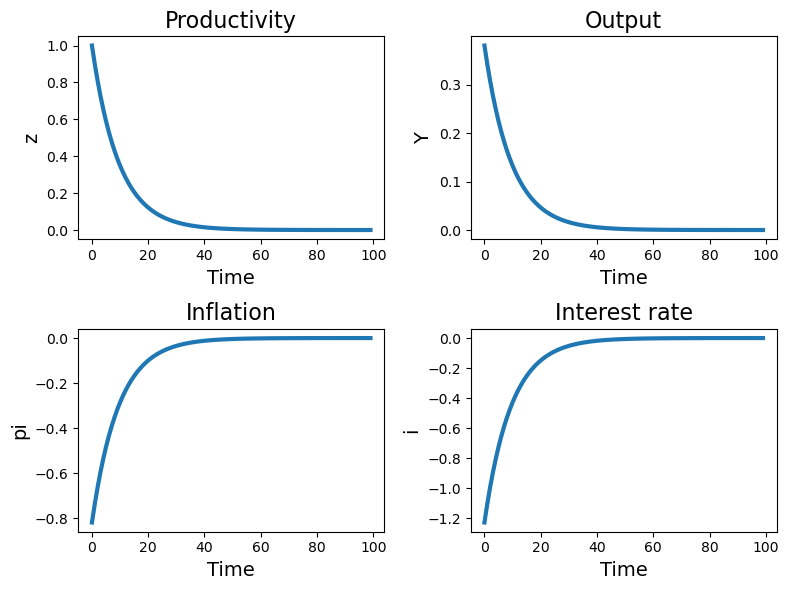

In [38]:
# Plot the graph
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

axs[0, 0].plot(range(T), dZ, linewidth=3)
axs[0, 0].set_xlabel('Time', fontsize=14)
axs[0, 0].set_ylabel('z', fontsize=14)
axs[0, 0].set_title('Productivity', fontsize=16)

axs[0, 1].plot(range(T), dU, linewidth=3)
axs[0, 1].set_xlabel('Time', fontsize=14)
axs[0, 1].set_ylabel('Y', fontsize=14)
axs[0, 1].set_title('Output', fontsize=16)

axs[1, 0].plot(range(T), dY[:T], linewidth=3)
axs[1, 0].set_xlabel('Time', fontsize=14)
axs[1, 0].set_ylabel('pi', fontsize=14)
axs[1, 0].set_title('Inflation', fontsize=16)

axs[1, 1].plot(range(T), dY[T:2*T], linewidth=3)
axs[1, 1].set_xlabel('Time', fontsize=14)
axs[1, 1].set_ylabel('i', fontsize=14)
axs[1, 1].set_title('Interest rate', fontsize=16)

plt.tight_layout()
plt.show()